# EAS503 Final Project - Varun Singh

Import Statements

In [1]:
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from ydata_profiling import ProfileReport
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")
import mlflow
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import mlflow.sklearn

Normalisation Script

In [2]:
'''
The code normalises the data and creates a normalised database through functions that create a table.
'''

class DataNormalizer:
    def __init__(self, csv_file, db_file):
        self.csv_file = csv_file
        self.db_file = db_file
        os.makedirs(os.path.dirname(self.db_file), exist_ok=True)
        self.conn = sqlite3.connect(self.db_file)
        self.cursor = self.conn.cursor()
        self.cursor.execute("PRAGMA foreign_keys = ON;")
        self.conn.commit()

    def create_patients_table(self):
        self.cursor.execute("DROP TABLE IF EXISTS Patients")
        self.cursor.execute('''
        CREATE TABLE Patients (
            PatientID INTEGER PRIMARY KEY AUTOINCREMENT,
            State TEXT,
            Sex TEXT,
            AgeCategory TEXT,
            RaceEthnicityCategory TEXT,
            HeightInMeters REAL,
            WeightInKilograms REAL,
            BMI REAL
        )''')
        
        data = []
        with open(self.csv_file, 'r') as file:
            next(file)
            for line in file:
                row = line.strip().split(',')
                data.append((row[0], row[1], row[29], row[28], row[30], row[31], row[32]))

        self.cursor.executemany('''
        INSERT INTO Patients (State, Sex, AgeCategory, RaceEthnicityCategory, HeightInMeters, WeightInKilograms, BMI)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', data)
        
        self.conn.commit()

    def create_health_status_table(self):
        self.cursor.execute("DROP TABLE IF EXISTS HealthStatus")
        self.cursor.execute('''
        CREATE TABLE HealthStatus (
            HealthStatusID INTEGER PRIMARY KEY AUTOINCREMENT,
            PatientID INTEGER,
            GeneralHealth TEXT,
            PhysicalHealthDays INTEGER,
            MentalHealthDays INTEGER,
            LastCheckupTime TEXT,
            FOREIGN KEY (PatientID) REFERENCES Patients(PatientID)
        )''')
        
        data = []
        with open(self.csv_file, 'r') as file:
            next(file)
            for idx, line in enumerate(file, 1):
                row = line.strip().split(',')
                data.append((idx, row[2], row[3], row[4], row[5]))

        self.cursor.executemany('''
        INSERT INTO HealthStatus (PatientID, GeneralHealth, PhysicalHealthDays, MentalHealthDays, LastCheckupTime)
        VALUES (?, ?, ?, ?, ?)
        ''', data)
        
        self.conn.commit()

    def create_lifestyle_table(self):
        self.cursor.execute("DROP TABLE IF EXISTS Lifestyle")
        self.cursor.execute('''
        CREATE TABLE Lifestyle (
            LifestyleID INTEGER PRIMARY KEY AUTOINCREMENT,
            PatientID INTEGER,
            PhysicalActivities TEXT,
            SleepHours INTEGER,
            AlcoholDrinkers TEXT,
            SmokerStatus TEXT,
            ECigaretteUsage TEXT,
            FOREIGN KEY (PatientID) REFERENCES Patients(PatientID)
        )''')
        
        data = []
        with open(self.csv_file, 'r') as file:
            next(file)
            for idx, line in enumerate(file, 1):
                row = line.strip().split(',')
                data.append((idx, row[6], row[7], row[33], row[25], row[26]))

        self.cursor.executemany('''
        INSERT INTO Lifestyle (PatientID, PhysicalActivities, SleepHours, AlcoholDrinkers, SmokerStatus, ECigaretteUsage)
        VALUES (?, ?, ?, ?, ?, ?)
        ''', data)

        self.conn.commit()

    def create_medical_history_table(self):
        self.cursor.execute("DROP TABLE IF EXISTS MedicalHistory")
        self.cursor.execute('''
        CREATE TABLE MedicalHistory (
            MedicalHistoryID INTEGER PRIMARY KEY AUTOINCREMENT,
            PatientID INTEGER,
            RemovedTeeth TEXT,
            HadHeartAttack TEXT,
            HadAngina TEXT,
            HadStroke TEXT,
            HadAsthma TEXT,
            HadSkinCancer TEXT,
            HadCOPD TEXT,
            HadDepressiveDisorder TEXT,
            HadKidneyDisease TEXT,
            HadArthritis TEXT,
            HadDiabetes TEXT,
            FOREIGN KEY (PatientID) REFERENCES Patients(PatientID)
        )''')
        
        data = []
        with open(self.csv_file, 'r') as file:
            next(file)
            for idx, line in enumerate(file, 1):
                row = line.strip().split(',')
                data.append((idx, row[8], row[9], row[10], row[11], row[12], row[13], row[14], row[15], row[16], row[17], row[18]))

        self.cursor.executemany('''
        INSERT INTO MedicalHistory (PatientID, RemovedTeeth, HadHeartAttack, HadAngina, HadStroke, HadAsthma, HadSkinCancer, HadCOPD, HadDepressiveDisorder, HadKidneyDisease, HadArthritis, HadDiabetes)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', data)

        self.conn.commit()

    def create_disabilities_table(self):
        self.cursor.execute("DROP TABLE IF EXISTS Disabilities")
        self.cursor.execute('''
        CREATE TABLE Disabilities (
            DisabilityID INTEGER PRIMARY KEY AUTOINCREMENT,
            PatientID INTEGER,
            DeafOrHardOfHearing TEXT,
            BlindOrVisionDifficulty TEXT,
            DifficultyConcentrating TEXT,
            DifficultyWalking TEXT,
            DifficultyDressingBathing TEXT,
            DifficultyErrands TEXT,
            FOREIGN KEY (PatientID) REFERENCES Patients(PatientID)
        )''')
        
        data = []
        with open(self.csv_file, 'r') as file:
            next(file)
            for idx, line in enumerate(file, 1):
                row = line.strip().split(',')
                data.append((idx, row[19], row[20], row[21], row[22], row[23], row[24]))

        self.cursor.executemany('''
        INSERT INTO Disabilities (PatientID, DeafOrHardOfHearing, BlindOrVisionDifficulty, DifficultyConcentrating, DifficultyWalking, DifficultyDressingBathing, DifficultyErrands)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', data)

        self.conn.commit()

    def create_preventive_care_table(self):
        self.cursor.execute("DROP TABLE IF EXISTS PreventiveCare")
        self.cursor.execute('''
        CREATE TABLE PreventiveCare (
            PreventiveCareID INTEGER PRIMARY KEY AUTOINCREMENT,
            PatientID INTEGER,
            ChestScan TEXT,
            HIVTesting TEXT,
            FluVaxLast12 TEXT,
            PneumoVaxEver TEXT,
            TetanusLast10Tdap TEXT,
            FOREIGN KEY (PatientID) REFERENCES Patients(PatientID)
        )''')
        
        data = []
        with open(self.csv_file, 'r') as file:
            next(file)
            for idx, line in enumerate(file, 1):
                row = line.strip().split(',')
                data.append((idx, row[27], row[34], row[35], row[36], row[37]))

        self.cursor.executemany('''
        INSERT INTO PreventiveCare (PatientID, ChestScan, HIVTesting, FluVaxLast12, PneumoVaxEver, TetanusLast10Tdap)
        VALUES (?, ?, ?, ?, ?, ?)
        ''', data)

        self.conn.commit()

    def create_risk_factors_table(self):
        self.cursor.execute("DROP TABLE IF EXISTS RiskFactors")
        self.cursor.execute('''
        CREATE TABLE RiskFactors (
            RiskFactorID INTEGER PRIMARY KEY AUTOINCREMENT,
            PatientID INTEGER,
            HighRiskLastYear TEXT,
            CovidPos TEXT,
            FOREIGN KEY (PatientID) REFERENCES Patients(PatientID)
        )''')
        
        data = []
        with open(self.csv_file, 'r') as file:
            next(file)
            for idx, line in enumerate(file, 1):
                row = line.strip().split(',')
                data.append((idx, row[38], row[39]))

        self.cursor.executemany('''
        INSERT INTO RiskFactors (PatientID, HighRiskLastYear, CovidPos)
        VALUES (?, ?, ?)
        ''', data)

        self.conn.commit()

    def close_connection(self):
        self.conn.close()

    def run(self):
        try:
            print(f"Creating database: {self.db_file}")
            print("Creating Patients table...")
            self.create_patients_table()
            print("Creating HealthStatus table...")
            self.create_health_status_table()
            print("Creating Lifestyle table...")
            self.create_lifestyle_table()
            print("Creating MedicalHistory table...")
            self.create_medical_history_table()
            print("Creating Disabilities table...")
            self.create_disabilities_table()
            print("Creating PreventiveCare table...")
            self.create_preventive_care_table()
            print("Creating RiskFactors table...")
            self.create_risk_factors_table()
            print("All tables created successfully")
        except sqlite3.Error as e:
            print(f"An error occurred: {e}")
        finally:
            self.close_connection()


csv_file = r"C:\Users\singh\Downloads\503 Project\heart_2022_with_nans.csv"
if not os.path.exists(csv_file):
    print(f"CSV file not found: {csv_file}")
    exit(1)

db_file = r"C:\Users\singh\Downloads\503 Project\normalized2.db"
if os.path.exists(db_file):
    os.remove(db_file)
    print(f"Existing database file deleted: {db_file}")

normalizer = DataNormalizer(csv_file, db_file)
normalizer.run()

Existing database file deleted: C:\Users\singh\Downloads\503 Project\normalized2.db
Creating database: C:\Users\singh\Downloads\503 Project\normalized2.db
Creating Patients table...
Creating HealthStatus table...
Creating Lifestyle table...
Creating MedicalHistory table...
Creating Disabilities table...
Creating PreventiveCare table...
Creating RiskFactors table...
All tables created successfully


Dataframe Merging Script

In [3]:
'''
Joins all tables in normalised db to create a dataframe for EDA and Pre-processing
'''

def join_all_tables(db_file):
    conn = sqlite3.connect(db_file)
    
    query = """
    SELECT 
        Patients.PatientID,
        Patients.State,
        Patients.Sex,
        Patients.AgeCategory,
        Patients.RaceEthnicityCategory,
        Patients.HeightInMeters,
        Patients.WeightInKilograms,
        Patients.BMI,
        HealthStatus.GeneralHealth,
        HealthStatus.PhysicalHealthDays,
        HealthStatus.MentalHealthDays,
        HealthStatus.LastCheckupTime,
        Lifestyle.PhysicalActivities,
        Lifestyle.SleepHours,
        Lifestyle.AlcoholDrinkers,
        Lifestyle.SmokerStatus,
        Lifestyle.ECigaretteUsage,
        MedicalHistory.RemovedTeeth,
        MedicalHistory.HadHeartAttack,
        MedicalHistory.HadAngina,
        MedicalHistory.HadStroke,
        MedicalHistory.HadAsthma,
        MedicalHistory.HadSkinCancer,
        MedicalHistory.HadCOPD,
        MedicalHistory.HadDepressiveDisorder,
        MedicalHistory.HadKidneyDisease,
        MedicalHistory.HadArthritis,
        MedicalHistory.HadDiabetes,
        Disabilities.DeafOrHardOfHearing,
        Disabilities.BlindOrVisionDifficulty,
        Disabilities.DifficultyConcentrating,
        Disabilities.DifficultyWalking,
        Disabilities.DifficultyDressingBathing,
        Disabilities.DifficultyErrands,
        PreventiveCare.ChestScan,
        PreventiveCare.HIVTesting,
        PreventiveCare.FluVaxLast12,
        PreventiveCare.PneumoVaxEver,
        PreventiveCare.TetanusLast10Tdap,
        RiskFactors.HighRiskLastYear,
        RiskFactors.CovidPos
    FROM Patients
    JOIN HealthStatus ON Patients.PatientID = HealthStatus.PatientID
    JOIN Lifestyle ON Patients.PatientID = Lifestyle.PatientID
    JOIN MedicalHistory ON Patients.PatientID = MedicalHistory.PatientID
    JOIN Disabilities ON Patients.PatientID = Disabilities.PatientID
    JOIN PreventiveCare ON Patients.PatientID = PreventiveCare.PatientID
    JOIN RiskFactors ON Patients.PatientID = RiskFactors.PatientID
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    return df

db_file = r"C:\Users\singh\Downloads\503 Project\normalized2.db"
joined_df = join_all_tables(db_file)

joined_df.to_csv(r"C:\Users\singh\Downloads\503 Project\joined.csv", index=False)

print("Joined data saved to 'joined_patient_data.csv'")


Joined data saved to 'joined_patient_data.csv'


Data Profiling and EDA

In [4]:
'''
Copying the dataframe, and creating the response variable as a sum of three Heart Disease related variables, as well as removing some non-related variables
'''
df = joined_df.copy()
df["HadHeartIssues"] = df[["HadHeartAttack", "HadAngina", "HadStroke"]].apply(
    lambda row: "Yes" if "Yes" in row.values else "No", axis=1)
df.drop(columns=["HadHeartAttack", "HadAngina", "HadStroke", "RemovedTeeth", "TetanusLast10Tdap", "State", "PatientID"], inplace=True)
profile = ProfileReport(df, title="Pandas Profiling Report")
profile


We can see the profile above, which shows all the columns that are being used, as well as the range of values, alerts, covariance matrix, plots, heatmaps, etc. 

There are around 445,000 rows. However the profile also shows us that our response variable has high imbalance of class, which we will need to take care for in the next steps, through undersampling, which will reduce our row count significantly

There are other variables that have issues, such as state having a high cardinality, missing data values, etc

The following code will perform basic cleanup tasks and make the data ready for use

In [5]:
'''
Below code performs a bunch of cleanup tasks that were determined from stufying the data. 
Some of these columns, though useful for other prediction tasks (such as if a person has SkinCancer or not),
are not relevant for this prediction. Further, values such as Yes and No have been converted to True and false, as well as
numeric columns have been cleaned to maintain data type consistencies
We can compare the profiles at the end and see that this data is more suited for processing
'''

# Function to convert yes/no to boolean
def yes_no_to_bool(value):
    if pd.isna(value):
        return np.nan
    return value.lower() == 'yes'

# Standardize columns
df['Sex'] = df['Sex'].astype('category')
df['AgeCategory'] = df['AgeCategory'].astype('category')
df['RaceEthnicityCategory'] = df['RaceEthnicityCategory'].astype('category')
df['HeightInMeters'] = pd.to_numeric(df['HeightInMeters'], errors='coerce')
df['WeightInKilograms'] = pd.to_numeric(df['WeightInKilograms'], errors='coerce')
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')
df['GeneralHealth'] = df['GeneralHealth'].astype('category')
df['PhysicalHealthDays'] = pd.to_numeric(df['PhysicalHealthDays'], errors='coerce')
df['MentalHealthDays'] = pd.to_numeric(df['MentalHealthDays'], errors='coerce')
df['LastCheckupTime'] = df['LastCheckupTime'].astype('category')
df['SleepHours'] = pd.to_numeric(df['SleepHours'], errors='coerce')
df['SmokerStatus'] = df['SmokerStatus'].astype('category')
df['ECigaretteUsage'] = df['ECigaretteUsage'].astype('category')
had_columns = [col for col in df.columns if col.startswith('Had')]
for col in had_columns:
    df[col] = df[col].apply(yes_no_to_bool)
binary_columns = [
    "DeafOrHardOfHearing", "BlindOrVisionDifficulty", "DifficultyConcentrating",
    "DifficultyWalking", "DifficultyDressingBathing", "DifficultyErrands",
    "FluVaxLast12", "PneumoVaxEver", "HighRiskLastYear", "CovidPos", "PhysicalActivities",
    "AlcoholDrinkers", "ChestScan", "HIVTesting"
]
for col in binary_columns:
    df[col] = df[col].apply(yes_no_to_bool)
categorical_columns = ['ECigaretteUsage', 'LastCheckupTime', 'GeneralHealth', 
                       'RaceEthnicityCategory', 'AgeCategory', 'SmokerStatus']
for column in categorical_columns:
    df = df[df[column].notna() & (df[column] != '')]
numeric_columns = ['HeightInMeters', 'WeightInKilograms', 'BMI', 
                   'PhysicalHealthDays', 'MentalHealthDays', 'SleepHours']
for column in numeric_columns:
    df = df[df[column].notna()]
df = df.dropna()
df.to_csv(r"C:\Users\singh\Downloads\503 Project\cleaned_joined2.csv", index=False)

profile = ProfileReport(df, title="Pandas Profiling Report")
profile


In [6]:
'''
We need to perfrom Undersampling as there is a great class imbalance in our response variable.
The below code tries to fix that by taking only a subset of the False class
'''

X = df.drop('HadHeartIssues', axis=1)
y = df['HadHeartIssues']
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
df_undersampled = pd.DataFrame(X_resampled, columns=X.columns)
df_undersampled['HadHeartIssues'] = y_resampled
df = df_undersampled
df.to_csv(r"C:\Users\singh\Downloads\503 Project\cleaned_joined3.csv", index=False)

#We can check the profile again at the end to see if the data is now cleaned
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

#Alerts that were ignored
# - 17 duplicate rows - Duplicacy arrives from deletion of some variables, and has only 17 rows, hence was ignored

In [7]:
import os
import mlflow

# Set tracking URI and credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/singhvarunnn789/EAS503.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "singhvarunnn789"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "0b1c49603d59c6ba067650000962ccbb763351a5"

# Set the tracking URI
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Set experiment
mlflow.set_experiment("logistic_regression_experiment")

<Experiment: artifact_location='mlflow-artifacts:/86d8cd44ef014a1a85602108549a0d9c', creation_time=1734611106268, experiment_id='0', last_update_time=1734611106268, lifecycle_stage='active', name='logistic_regression_experiment', tags={}>

### Splitting the data into test and train sets in a ratio of 2:8

In [8]:
# Split the data
X = df.drop('HadHeartIssues', axis=1)
y = df['HadHeartIssues']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Experiment 1

### Pipeline for Pre-processing

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('minmax', MinMaxScaler()),
    ('log', FunctionTransformer(np.log1p, validate=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### Create pipeline for Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

### Parameter Hypertuning

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


### 10 - fold Cross validation

In [12]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')


## Logging results in MLFlow

In [13]:
import mlflow
from mlflow.models import infer_signature
import os

# Set MLflow tracking URI
MLFLOW_TRACKING_URI = "https://dagshub.com/singhvarunnn789/EAS503.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'singhvarunnn789'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '0b1c49603d59c6ba067650000962ccbb763351a5'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("logistic_regression_experiment")

y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Log results with MLflow
with mlflow.start_run():
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("cv_f1_mean", np.mean(cv_scores))
    mlflow.log_metric("cv_f1_std", np.std(cv_scores))
    
    # Log the model
    signature = infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="logistic_regression_model",
        signature=signature,
        input_example=X_train.iloc[0].to_dict(),
        registered_model_name="LogisticRegressionModel"
    )

print(f"Best parameters: {grid_search.best_params_}")
print(f"F1-score on test set: {f1:.4f}")
print(f"Confusion matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Cross-validation F1-scores - Mean: {np.mean(cv_scores):.4f}, Std: {np.std(cv_scores):.4f}")


Registered model 'LogisticRegressionModel' already exists. Creating a new version of this model...
2024/12/20 16:15:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegressionModel, version 25
Created version '25' of model 'LogisticRegressionModel'.


🏃 View run omniscient-wasp-764 at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/0/runs/14f3f32e18da451c812763a78f080e3e
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/0
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
F1-score on test set: 0.5963
Confusion matrix: TN=6511, FP=1630, FN=4696, TP=3418
Cross-validation F1-scores - Mean: 0.5144, Std: 0.0083


### Adding the results of Experiments as a dictionary to a list so we can plot the F1 scores at the end

In [14]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"F1-score on test set: {f1:.4f}")
print(f"Confusion matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Cross-validation F1-scores - Mean: {np.mean(cv_scores):.4f}, Std: {np.std(cv_scores):.4f}")


experiment_results = {
    "experiment_name": "Experiment 1: Logistic Regression",
    "f1_score": f1,
    "confusion_matrix": {
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    },
    "cv_f1_mean": np.mean(cv_scores),
    "cv_f1_std": np.std(cv_scores)
}


all_experiment_results = []
all_experiment_results.append(experiment_results)

Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
F1-score on test set: 0.5963
Confusion matrix: TN=6511, FP=1630, FN=4696, TP=3418
Cross-validation F1-scores - Mean: 0.5144, Std: 0.0083


## Experiment 2

### Pipeline for pre-processing

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### Pipeline for Logistic Regression, Ridge, RandomForest, and XGClassifier

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Create pipelines for each classifier
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RidgeClassifier())
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])


### Model Fitting for Logistic Regression, Ridge, RandomForest, and XGBClassfier

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# List of pipelines
pipelines = [
    ('LogisticRegression', log_reg_pipeline),
    ('RidgeClassifier', ridge_pipeline),
    ('RandomForestClassifier', rf_pipeline),
    ('XGBClassifier', xgb_pipeline)
]

for name, pipeline in pipelines:
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name}:")
    print(f"  CV F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test F1-score: {f1:.4f}")

LogisticRegression:
  CV F1-score: 0.4999 (+/- 0.0175)
  Test Accuracy: 0.6110
  Test F1-score: 0.5933
RidgeClassifier:
  CV F1-score: 0.4932 (+/- 0.0168)
  Test Accuracy: 0.6098
  Test F1-score: 0.5903
RandomForestClassifier:
  CV F1-score: 0.5765 (+/- 0.0078)
  Test Accuracy: 0.5811
  Test F1-score: 0.5809
XGBClassifier:
  CV F1-score: 0.5952 (+/- 0.0130)
  Test Accuracy: 0.6226
  Test F1-score: 0.6211


### Logging results in MLFlow

In [18]:
import mlflow
import os

# Set MLflow tracking URI
MLFLOW_TRACKING_URI = "https://dagshub.com/singhvarunnn789/EAS503.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'singhvarunnn789'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '0b1c49603d59c6ba067650000962ccbb763351a5'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("classifier_comparison")

# Log results with MLflow
for name, pipeline in pipelines:
    with mlflow.start_run(run_name=name):
        # Log the model
        mlflow.sklearn.log_model(pipeline, f"{name}_model")
        
        # Log metrics
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        mlflow.log_metric("test_accuracy", accuracy)
        mlflow.log_metric("test_f1", f1)
        
        # Log parameters
        mlflow.log_params(pipeline.get_params())


2024/12/20 16:16:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/1/runs/154efc83d7f54e6aa225d252f6a4ddfe
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/1


2024/12/20 16:16:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/1/runs/3d6e036e6d11481db246b386b029fad4
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/1


2024/12/20 16:16:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/1/runs/14e87d21a7364daa975c07688e1c2448
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/1


2024/12/20 16:20:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/1/runs/4ca54ac31bc44e47aff04140dece8511
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/1


### Adding the results of Experiments as a dictionary to a list so we can plot the F1 scores at the end

In [19]:
experiment_results = []

for name, pipeline in pipelines:
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    result = {
        "experiment_name": f"Experiment 2: {name}",
        "cv_f1_mean": cv_scores.mean(),
        "cv_f1_std": cv_scores.std(),
        "test_accuracy": accuracy,
        "test_f1": f1
    }
    experiment_results.append(result)

# Add these results to the overall list of experiment results
all_experiment_results.extend(experiment_results)

## Experiment 3

### Feature Engineering

SMOTE was also used in this step as the classes were really unbalanced, which was causing bias and a low F1 score

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import BaseEstimator, TransformerMixin
import mlflow

# Custom Transformer for Feature Engineering
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['BMI_category'] = pd.cut(X['BMI'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
        age_map = {'Age 18 to 24': 21, 'Age 25 to 29': 27, 'Age 30 to 34': 32, 'Age 35 to 39': 37,
                   'Age 40 to 44': 42, 'Age 45 to 49': 47, 'Age 50 to 54': 52, 'Age 55 to 59': 57,
                   'Age 60 to 64': 62, 'Age 65 to 69': 67, 'Age 70 to 74': 72, 'Age 75 to 79': 77,
                   'Age 80 or older': 85}
        X['Age_BMI_interaction'] = X['AgeCategory'].map(age_map) * X['BMI']
        X['HealthScore'] = 30 - (X['PhysicalHealthDays'] + X['MentalHealthDays'])
        X['LifestyleScore'] = (
            X['PhysicalActivities'].astype(int) +
            ((X['SleepHours'] >= 7) & (X['SleepHours'] <= 9)).astype(int) +
            (~X['AlcoholDrinkers']).astype(int) +
            (X['SmokerStatus'] == 'Never smoked').astype(int)
        )
        comorbidity_columns = ['HadAsthma', 'HadSkinCancer', 'HadCOPD', 
                               'HadDepressiveDisorder', 'HadKidneyDisease', 
                               'HadArthritis', 'HadDiabetes']
        X['ComorbidityCount'] = X[comorbidity_columns].sum(axis=1)
        X['CheckedWithinYear'] = (X['LastCheckupTime'] == 'Within past year (anytime less than 12 months ago)').astype(int)
        
        return X

X = df.drop('HadHeartIssues', axis=1)
y = df['HadHeartIssues']

feature_engineer = FeatureEngineer()
X_engineered = feature_engineer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_engineered, y, test_size=0.2, random_state=42)



### Creating pipelines for preprocessing

In [21]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Create preprocessing steps for numeric and categorical features
numeric_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### Creating pipelines for Classification algorithms, similar to experiment 2

In [22]:
pipelines = [
    ('LogisticRegression', ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(random_state=42))
    ])),
    ('RidgeClassifier', ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RidgeClassifier(random_state=42))
    ])),
    ('RandomForestClassifier', ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])),
    ('XGBClassifier', ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', XGBClassifier(random_state=42))
    ]))
]

### Logging results in MLFlow

In [23]:
best_model = None
best_f1 = 0

# Set up MLflow for tracking experiments
mlflow.set_tracking_uri("https://dagshub.com/singhvarunnn789/EAS503.mlflow")
mlflow.set_experiment("Feature_Engineering")

with mlflow.start_run():
    for name, pipeline in pipelines:
        with mlflow.start_run(nested=True):
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
            pipeline.fit(X_train, y_train)
            
            y_pred = pipeline.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mlflow.log_param("model", name)
            if hasattr(pipeline.named_steps['classifier'], "n_estimators"):
                mlflow.log_param("n_estimators", pipeline.named_steps['classifier'].n_estimators)
            
            mlflow.log_metric("cv_f1_score", cv_scores.mean())
            mlflow.log_metric("test_accuracy", accuracy)
            mlflow.log_metric("test_f1_score", f1)

            print(f"{name}:")
            print(f" CV F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            print(f" Test Accuracy: {accuracy:.4f}")
            print(f" Test F1-score: {f1:.4f}")

            if f1 > best_f1:
                best_f1 = f1
                best_model = pipeline

print(f"\nBest model: {type(best_model.named_steps['classifier']).__name__}")
print(f"Best F1-score: {best_f1:.4f}")

LogisticRegression:
 CV F1-score: 0.7570 (+/- 0.0087)
 Test Accuracy: 0.7533
 Test F1-score: 0.7594
🏃 View run skillful-sponge-952 at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/2/runs/ce782d451afd44ec9c2187832fea2ba1
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/2
RidgeClassifier:
 CV F1-score: 0.7578 (+/- 0.0115)
 Test Accuracy: 0.7535
 Test F1-score: 0.7613
🏃 View run colorful-lark-880 at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/2/runs/90c6ae5f54a84232a5179d7cdd3b862f
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/2
RandomForestClassifier:
 CV F1-score: 0.7414 (+/- 0.0086)
 Test Accuracy: 0.7387
 Test F1-score: 0.7453
🏃 View run luminous-ape-361 at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/2/runs/f7309d24a54844ce9f9d6c4f0311a410
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/2
XGBClassifier:
 CV F1-s

## Saving The Ridge Model as the best model

In [ ]:
# After feature engineering
print("Columns after feature engineering:")
print(X_engineered.columns.tolist())

# Update numeric and categorical features
numeric_features = X_engineered.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_engineered.select_dtypes(include=['object', 'category']).columns.tolist()

# Recreate the preprocessor with updated feature lists
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Recreate the RidgeClassifier pipeline
ridge_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RidgeClassifier(random_state=42))
])

ridge_pipeline.fit(X_engineered, y)
import joblib
joblib.dump(ridge_pipeline, 'best_model_ridge.joblib')
sample_data = X_engineered.iloc[0].to_dict()
sample_df = pd.DataFrame([sample_data])
prediction = ridge_pipeline.predict(sample_df)


Columns after feature engineering:
['Sex', 'AgeCategory', 'RaceEthnicityCategory', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'AlcoholDrinkers', 'SmokerStatus', 'ECigaretteUsage', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear', 'CovidPos', 'BMI_category', 'Age_BMI_interaction', 'HealthScore', 'LifestyleScore', 'ComorbidityCount', 'CheckedWithinYear']
Model saved as 'best_model_ridge.joblib'

Preprocessor:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='me

### Adding the results of Experiments as a dictionary to a list so we can plot the F1 scores at the end

In [24]:
experiment_results = []

for name, pipeline in pipelines:
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    result = {
        "experiment_name": f"Experiment 3: {name} with Feature Engineering",
        "cv_f1_mean": cv_scores.mean(),
        "cv_f1_std": cv_scores.std(),
        "test_accuracy": accuracy,
        "test_f1": f1
    }
    experiment_results.append(result)

# Add these results to the overall list of experiment results
all_experiment_results.extend(experiment_results)

# Store the best model information
best_model_result = {
    "experiment_name": f"Experiment 3: Best Model - {type(best_model.named_steps['classifier']).__name__}",
    "test_f1": best_f1,
}
all_experiment_results.append(best_model_result)

## Experiment 4

Feature Selection

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import mlflow

class FeatureEngineer:
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['BMI_category'] = pd.cut(X['BMI'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
        age_map = {'Age 18 to 24': 21, 'Age 25 to 29': 27, 'Age 30 to 34': 32, 'Age 35 to 39': 37,
                   'Age 40 to 44': 42, 'Age 45 to 49': 47, 'Age 50 to 54': 52, 'Age 55 to 59': 57,
                   'Age 60 to 64': 62, 'Age 65 to 69': 67, 'Age 70 to 74': 72, 'Age 75 to 79': 77,
                   'Age 80 or older': 85}
        X['Age_BMI_interaction'] = X['AgeCategory'].map(age_map) * X['BMI']
        X['HealthScore'] = 30 - (X['PhysicalHealthDays'] + X['MentalHealthDays'])
        X['LifestyleScore'] = (
            X['PhysicalActivities'].astype(int) +
            ((X['SleepHours'] >= 7) & (X['SleepHours'] <= 9)).astype(int) +
            (~X['AlcoholDrinkers']).astype(int) +
            (X['SmokerStatus'] == 'Never smoked').astype(int)
        )
        comorbidity_columns = ['HadAsthma', 'HadSkinCancer', 'HadCOPD', 
                               'HadDepressiveDisorder', 'HadKidneyDisease', 
                               'HadArthritis', 'HadDiabetes']
        X['ComorbidityCount'] = X[comorbidity_columns].sum(axis=1)
        X['CheckedWithinYear'] = (X['LastCheckupTime'] == 'Within past year (anytime less than 12 months ago)').astype(int)
        return X

def correlation_threshold(X, threshold=0.8):
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    corr_matrix = X[numeric_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(columns=to_drop)

def variance_threshold(X, threshold=0.01):
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    selector = VarianceThreshold(threshold)
    X_numeric = X[numeric_cols]
    selector.fit(X_numeric)
    selected_numeric_cols = numeric_cols[selector.get_support()].tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    selected_cols = selected_numeric_cols + categorical_cols.tolist()
    return X[selected_cols]

X = df.drop('HadHeartIssues', axis=1)
y = df['HadHeartIssues']

feature_engineer = FeatureEngineer()
X_engineered = feature_engineer.transform(X)

print("Starting feature selection...")
X_corr = correlation_threshold(X_engineered)
X_selected = variance_threshold(X_corr)
print("Feature selection completed.")
if 'Sex' not in X_selected.columns:
    X_selected['Sex'] = X['Sex']

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

Starting feature selection...
Feature selection completed.


### Pipelines for pre-processing

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

### Pipelines for classification algorithms

In [43]:
classifiers = [
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('RidgeClassifier', RidgeClassifier(random_state=42)),
    ('RandomForestClassifier', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('XGBClassifier', XGBClassifier(random_state=42))
]

### Logging Results in MLFlow

In [44]:
mlflow.set_tracking_uri("https://dagshub.com/singhvarunnn789/EAS503.mlflow")
mlflow.set_experiment("Feature_Selection")

with mlflow.start_run():
    mlflow.log_param("n_features_original", X.shape[1])
    mlflow.log_param("n_features_final", X_selected.shape[1])
    
    for name, classifier in classifiers:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        mlflow.log_metric(f"{name}_cv_f1_score", cv_scores.mean())
        mlflow.log_metric(f"{name}_test_accuracy", accuracy)
        mlflow.log_metric(f"{name}_test_f1_score", f1)

        print(f"{name}:")
        print(f" CV F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f" Test Accuracy: {accuracy:.4f}")
        print(f" Test F1-score: {f1:.4f}")

print("Experiment completed.")

LogisticRegression:
 CV F1-score: 0.7570 (+/- 0.0089)
 Test Accuracy: 0.7534
 Test F1-score: 0.7595
RidgeClassifier:
 CV F1-score: 0.7579 (+/- 0.0108)
 Test Accuracy: 0.7539
 Test F1-score: 0.7618
RandomForestClassifier:
 CV F1-score: 0.7429 (+/- 0.0077)
 Test Accuracy: 0.7419
 Test F1-score: 0.7486
XGBClassifier:
 CV F1-score: 0.7536 (+/- 0.0097)
 Test Accuracy: 0.7526
 Test F1-score: 0.7614
🏃 View run persistent-stoat-949 at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/3/runs/54ed672a3b244f5d9626264aa75e675e
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/3
Experiment completed.


### Adding the results of Experiments as a dictionary to a list so we can plot the F1 scores at the end

In [45]:
experiment_results = []

for name, classifier in classifiers:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    result = {
        "experiment_name": f"Experiment 4: {name} with Feature Selection",
        "cv_f1_mean": cv_scores.mean(),
        "cv_f1_std": cv_scores.std(),
        "test_accuracy": accuracy,
        "test_f1": f1
    }
    experiment_results.append(result)

# Add these results to the overall list of experiment results
all_experiment_results.extend(experiment_results)

In [29]:
print(all_experiment_results)

[{'experiment_name': 'Experiment 1: Logistic Regression', 'f1_score': 0.5963351709658641, 'confusion_matrix': {'TN': 6511, 'FP': 1630, 'FN': 4696, 'TP': 3418}, 'cv_f1_mean': 0.5143968784013151, 'cv_f1_std': 0.008349098015545535}, {'experiment_name': 'Experiment 2: LogisticRegression', 'cv_f1_mean': 0.4999428588564096, 'cv_f1_std': 0.00874662016728795, 'test_accuracy': 0.6109504767763765, 'test_f1': 0.5932591979685936}, {'experiment_name': 'Experiment 2: RidgeClassifier', 'cv_f1_mean': 0.49318745745559694, 'cv_f1_std': 0.008377266578019512, 'test_accuracy': 0.609781605659797, 'test_f1': 0.5903170171463006}, {'experiment_name': 'Experiment 2: RandomForestClassifier', 'cv_f1_mean': 0.575534316884385, 'cv_f1_std': 0.004390790352801672, 'test_accuracy': 0.5810519840049215, 'test_f1': 0.5809471104388041}, {'experiment_name': 'Experiment 2: XGBClassifier', 'cv_f1_mean': 0.5951801721677257, 'cv_f1_std': 0.006505189170044682, 'test_accuracy': 0.6225776684097201, 'test_f1': 0.6210547722910602}, 

## Experiment 5

### Pipeline for Pre-processing

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import mlflow
import matplotlib.pyplot as plt

X = df.drop('HadHeartIssues', axis=1)
y = df['HadHeartIssues']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
X_preprocessed = preprocessor.fit_transform(X)


### Setting up PCA and Classification algorithms

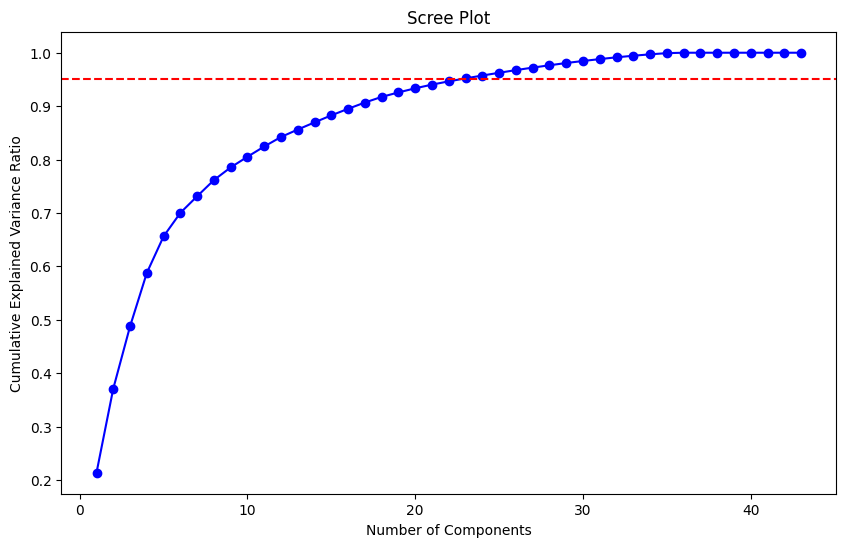

In [31]:
pca = PCA()
X_pca = pca.fit_transform(X_preprocessed)

# Create scree plot
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = len(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.savefig('scree_plot.png')
plt.show()
plt.close()

# Select number of components that explain 95% of variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
pca_95 = PCA(n_components=n_components_95)
X_pca_95 = pca_95.fit_transform(X_preprocessed)
X_train, X_test, y_train, y_test = train_test_split(X_pca_95, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

classifiers = [
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('RidgeClassifier', RidgeClassifier(random_state=42)),
    ('RandomForestClassifier', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('XGBClassifier', XGBClassifier(random_state=42))
]




### Logging Results in MLFlow

In [32]:
mlflow.set_tracking_uri("https://dagshub.com/singhvarunnn789/EAS503.mlflow")
mlflow.set_experiment("PCA_Dimensionality_Reduction")

with mlflow.start_run():
    mlflow.log_param("n_features_original", X.shape[1])
    mlflow.log_param("n_components_95", n_components_95)
    mlflow.log_artifact("scree_plot.png")
    
    for name, classifier in classifiers:
        clf = classifier.fit(X_train_resampled, y_train_resampled)
        cv_scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mlflow.log_metric(f"{name}_cv_f1_score", cv_scores.mean())
        mlflow.log_metric(f"{name}_test_accuracy", accuracy)
        mlflow.log_metric(f"{name}_test_f1_score", f1)
        print(f"{name}:")
        print(f" CV F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f" Test Accuracy: {accuracy:.4f}")
        print(f" Test F1-score: {f1:.4f}")
print("Experiment completed.")

LogisticRegression:
 CV F1-score: 0.7347 (+/- 0.0070)
 Test Accuracy: 0.7369
 Test F1-score: 0.7374
RidgeClassifier:
 CV F1-score: 0.7328 (+/- 0.0081)
 Test Accuracy: 0.7360
 Test F1-score: 0.7364
RandomForestClassifier:
 CV F1-score: 0.7320 (+/- 0.0109)
 Test Accuracy: 0.7289
 Test F1-score: 0.7352
XGBClassifier:
 CV F1-score: 0.7406 (+/- 0.0062)
 Test Accuracy: 0.7373
 Test F1-score: 0.7466
🏃 View run able-squirrel-364 at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/4/runs/13bcc0e6cd724099a5ea73e4773a0ef2
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/4
Experiment completed.


### ### Adding the results of Experiments as a dictionary to a list so we can plot the F1 scores at the end

In [33]:
# Store results for each classifier
experiment_results = []

for name, classifier in classifiers:
    clf = classifier.fit(X_train_resampled, y_train_resampled)
    cv_scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    result = {
        "experiment_name": f"Experiment 5: {name} with PCA",
        "cv_f1_mean": cv_scores.mean(),
        "cv_f1_std": cv_scores.std(),
        "test_accuracy": accuracy,
        "test_f1": f1,
    }
    experiment_results.append(result)

# Add these results to the overall list of experiment results
all_experiment_results.extend(experiment_results)

print("Results stored for Experiment 5.")


Results stored for Experiment 5.


## Custom Experiment 1

This experiment uses a pipeline with preprocessing, feature selection, and a Random Forest classifier. 

It employs grid search for hyperparameter tuning and Gradient Boosting for feature selection. 

The pipeline includes StandardScaler for numeric features and OneHotEncoder for categorical features. 

The experiment uses MLflow to track parameters, metrics, and the best model.

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import mlflow

# Load your dataset
X = df.drop('HadHeartIssues', axis=1)
y = df['HadHeartIssues']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline with preprocessing, feature selection, and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(GradientBoostingClassifier(random_state=42))),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define hyperparameters to tune
param_grid = {
    'feature_selection__estimator__n_estimators': [100, 200],
    'feature_selection__estimator__max_depth': [3, 5],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10],
    'classifier__min_samples_split': [2, 5]
}

# Set up MLflow for tracking experiments
mlflow.set_tracking_uri("https://dagshub.com/singhvarunnn789/EAS503.mlflow")
mlflow.set_experiment("Custom_Experiment_6")

with mlflow.start_run():
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log parameters and metrics
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    # Log the model
    mlflow.sklearn.log_model(best_model, "best_model")

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")

print("Custom experiment completed.")


2024/12/20 16:40:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'feature_selection__estimator__max_depth': 3, 'feature_selection__estimator__n_estimators': 100}
Accuracy: 0.7347
F1-score: 0.7440
🏃 View run glamorous-seal-852 at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/5/runs/ba69d46310624cc9adf26931f677a701
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/5
Custom experiment completed.


### Adding the results of Experiments as a dictionary to a list so we can plot the F1 scores at the end

In [35]:
# Store results for the custom experiment
experiment_result = {
    "experiment_name": "Experiment 6: Custom Pipeline with Feature Selection",
    "test_accuracy": accuracy,
    "test_f1": f1,
    "cv_f1_mean": grid_search.best_score_,
    "cv_f1_std": grid_search.cv_results_['std_test_score'][grid_search.best_index_],
}
all_experiment_results.append(experiment_result)

print("Results stored for Experiment 6.")


Results stored for Experiment 6.


## Custom Experiment 2

This experiment focuses on ensemble methods and advanced feature engineering. 

It uses a stacking classifier combining Random Forest and Gradient Boosting, with Logistic Regression as the final estimator. 

The pipeline includes preprocessing and Bayesian optimization for hyperparameter tuning. 

The experiment logs results in MLflow.

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from skopt import BayesSearchCV
import mlflow

def create_interaction_features(X):
    age_map = {'Age 18 to 24': 21, 'Age 25 to 29': 27, 'Age 30 to 34': 32, 'Age 35 to 39': 37,
               'Age 40 to 44': 42, 'Age 45 to 49': 47, 'Age 50 to 54': 52, 'Age 55 to 59': 57,
               'Age 60 to 64': 62, 'Age 65 to 69': 67, 'Age 70 to 74': 72, 'Age 75 to 79': 77,
               'Age 80 or older': 85}
    X['Age'] = X['AgeCategory'].map(age_map)
    X['BMI_Age'] = X['BMI'] * X['Age']
    X['ComorbidityScore'] = X[['HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 
                               'HadKidneyDisease', 'HadArthritis', 'HadDiabetes']].sum(axis=1)
    return X

X = df.drop('HadHeartIssues', axis=1)
y = df['HadHeartIssues']

X = create_interaction_features(X)

# Use a smaller subset of data for faster execution
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

base_estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]

stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=42),
    cv=3
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', stacking_classifier)
])

param_space = {
    'classifier__rf__n_estimators': (50, 200),
    'classifier__gb__n_estimators': (50, 200),
    'classifier__final_estimator__C': (1e-3, 1e3, 'log-uniform')
}

bayes_search = BayesSearchCV(
    pipeline, param_space, n_iter=20, cv=3, scoring='f1', random_state=42, n_jobs=-1
)

mlflow.set_tracking_uri("https://dagshub.com/singhvarunnn789/EAS503.mlflow")
mlflow.set_experiment("Custom_Experiment_7")

with mlflow.start_run():
    bayes_search.fit(X_train, y_train)
    
    best_model = bayes_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    mlflow.log_params(bayes_search.best_params_)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.sklearn.log_model(best_model, "best_model")
    
    print(f"Best parameters: {bayes_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")

print("Custom experiment completed.")


2024/12/20 16:45:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best parameters: OrderedDict({'classifier__final_estimator__C': 1000.0, 'classifier__gb__n_estimators': 50, 'classifier__rf__n_estimators': 155})
Accuracy: 0.7468
F1-score: 0.7573
🏃 View run caring-sponge-29 at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/6/runs/57bab3379c5a4440a99ddb20a3fa28a4
🧪 View experiment at: https://dagshub.com/singhvarunnn789/EAS503.mlflow/#/experiments/6
Custom experiment completed.


### Adding the results of Experiments as a dictionary to a list so we can plot the F1 scores at the end

In [37]:
# Store results for the custom experiment
experiment_result = {
    "experiment_name": "Experiment 7: Stacking Classifier with Bayesian Optimization",
    "test_accuracy": accuracy,
    "test_f1": f1,
    "cv_f1_mean": bayes_search.best_score_,
}

# Add this result to the overall list of experiment results
all_experiment_results.append(experiment_result)

print("Results stored for Experiment 7.")

Results stored for Experiment 7.


# Creating F1 Score Plots

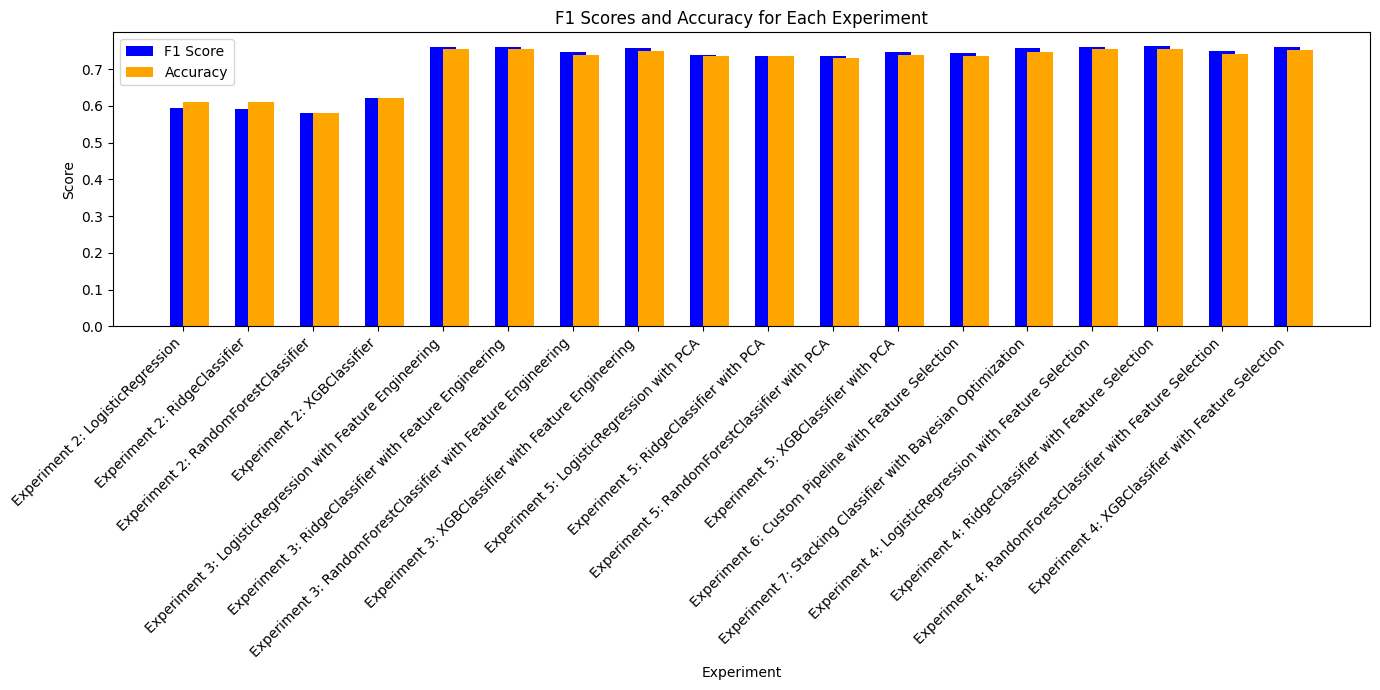

In [47]:
import matplotlib.pyplot as plt

# Extract experiment names, F1 scores, and accuracy scores, handling missing keys
def get_metric(result, key):
    return result.get(key, None)

experiment_names = [result['experiment_name'] for result in all_experiment_results]
f1_scores = [get_metric(result, 'test_f1') or get_metric(result, 'f1_score') for result in all_experiment_results]
accuracy_scores = [get_metric(result, 'test_accuracy') for result in all_experiment_results]

# Filter out None values for plotting
valid_indices = [i for i, f1 in enumerate(f1_scores) if f1 is not None and accuracy_scores[i] is not None]
experiment_names = [experiment_names[i] for i in valid_indices]
f1_scores = [f1_scores[i] for i in valid_indices]
accuracy_scores = [accuracy_scores[i] for i in valid_indices]

# Create the bar plot
plt.figure(figsize=(14, 7))
x = range(len(experiment_names))
plt.bar(x, f1_scores, width=0.4, label='F1 Score', color='blue', align='center')
plt.bar(x, accuracy_scores, width=0.4, label='Accuracy', color='orange', align='edge')

# Add labels and title
plt.xticks(x, experiment_names, rotation=45, ha='right')
plt.xlabel('Experiment')
plt.ylabel('Score')
plt.title('F1 Scores and Accuracy for Each Experiment')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
